In [35]:
%matplotlib widget

In [1]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
seed=2024

### Define functions

In [2]:
def to_python_hdf5(dat:List, save_path: Path):
    """Save data in hdf5 format."""
    # save the data
    with h5py.File(save_path, "w") as f:
        for i_d in range(len(dat)):
            group = f.create_group(str(i_d))

            for key, value in zip(dat[i_d].keys(), dat[i_d].values()):
                group.create_dataset(key, np.array(value).shape, data=value)
    f.close()

In [3]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [4]:
def z_score(x):
    mu = np.mean(x,axis=0)
    sigma = np.std(x,axis=0)
    sigma0=sigma
    sigma0[sigma == 0] = 1 
    zs_x = (x-mu) / sigma0
    return zs_x

In [5]:
def get_fr_samples(sp,sample_id,time_before,start,end,samples):
    # parameters
    n_trials = 5
    win=50
    # Check fr
    ms_fr=np.nanmean(sp[:,start:end])*1000>5
    if not ms_fr:
        return None
    # Average spikes
    avg_sample = firing_rate.moving_average(sp, win=win, step = 1)
    fr_samples = []
    for s_id in samples:
        sample_fr = avg_sample[np.where(sample_id==s_id,True,False),start:end]
        # Check number of trials
        if sample_fr.shape[0]< n_trials:
            return None
        fr_samples.append(np.mean(sample_fr,axis=0))
    return fr_samples


In [6]:
def get_neuron_sample_fr(path,time_before,start,end,rng):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    # Select trials aligned to sample onset
    sp_sample_on,mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    if np.sum(mask)<20:
        return {'fr':None}
    sample_id = neu_data.sample_id[mask]
    fr_samples = get_fr_samples(sp_sample_on,sample_id,time_before=time_before,start=start,end=end,samples=[0,11,15,55,51])
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

In [7]:
# def get_neuron_sample_fr(path,time_before,start,end,rng):
#     neu_data = NeuronData.from_python_hdf5(path)
#     fr_samples = get_fr_samples(neu_data,time_before=time_before,start=start,end=end)
#     if fr_samples is None:
#         return {'fr':None}
#     return {'fr':fr_samples}

In [8]:
def get_neuron_sample_test1_fr(path,time_before,start,end,end_test,n_test,rng):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on, mask_sample = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    sp_test1_on, mask_test1 = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="test_on_1",
        time_before = 200,
        error_type= 0,
    )
    if np.any(mask_sample != mask_test1):
        print(path)
        return 
    mask_match=np.where(neu_data.test_stimuli[mask_test1,n_test-1]==neu_data.sample_id[mask_test1],True,False)
    # mask_roll_nan = np.where(neu_data.test_stimuli[mask_test1]==neu_data.sample_id[mask_test1])
    # mask_match = mask_roll_nan[:,n_test-1]
    mask_neu = neu_data.sample_id[mask_test1]==0
    mask_match_neu = np.logical_or(mask_match,mask_neu)
    if np.sum(mask_match_neu)<20:
        return {'fr':None}
 
    sp=np.concatenate((sp_sample_on[mask_match_neu,:time_before+450+200],sp_test1_on[mask_match_neu,:end_test+400]),axis=1)

    sample_id = neu_data.sample_id[mask_test1][mask_match_neu]
    fr_samples = get_fr_samples(sp,sample_id,time_before=time_before,start=idx_start,end=idx_end,samples=[0,11,15,55,51])
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

### Read data

In [9]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

In [10]:
neu_path = basepath+"/session_struct/lip/neurons/*neu.h5"
path_list = glob.glob(neu_path)

In [91]:
# Load data
time_before=500
start=-200
n_test=1
end_test = 200+n_test*450
end=450+200+end_test+200#850

idx_start = time_before + start 
idx_end = time_before+end
rng = np.random.default_rng(seed=seed)
data = Parallel(n_jobs = -1)(delayed(get_neuron_sample_test1_fr)(path,time_before,start,end,end_test,n_test,rng) for path in tqdm(path_list))

100%|██████████| 530/530 [01:37<00:00,  5.44it/s]


In [92]:
neurons_fr = []
for asc in data:
    fr = asc["fr"]
    if fr is not None:
        neurons_fr.append(asc)
to_python_hdf5(dat=neurons_fr, save_path='C:/Users/camil/Downloads/pca/lip_win50_test4_pca.h5')

In [93]:
neurons_fr_read=from_python_hdf5(load_path='C:/Users/camil/Downloads/pca/lip_win50_test4_pca.h5')
neurons_fr = []
for asc in neurons_fr_read:
    fr = asc["fr"]
    if fr is not None:
        fr_concat = np.concatenate(fr,axis=0)
        neurons_fr.append(fr_concat)

In [94]:
np.array(neurons_fr).shape

(201, 8500)

In [95]:
neurons_fr = np.array(neurons_fr)#.reshape(-1,1050)
neurons_fr.shape

(201, 8500)

In [96]:
(end-start) *5

8500

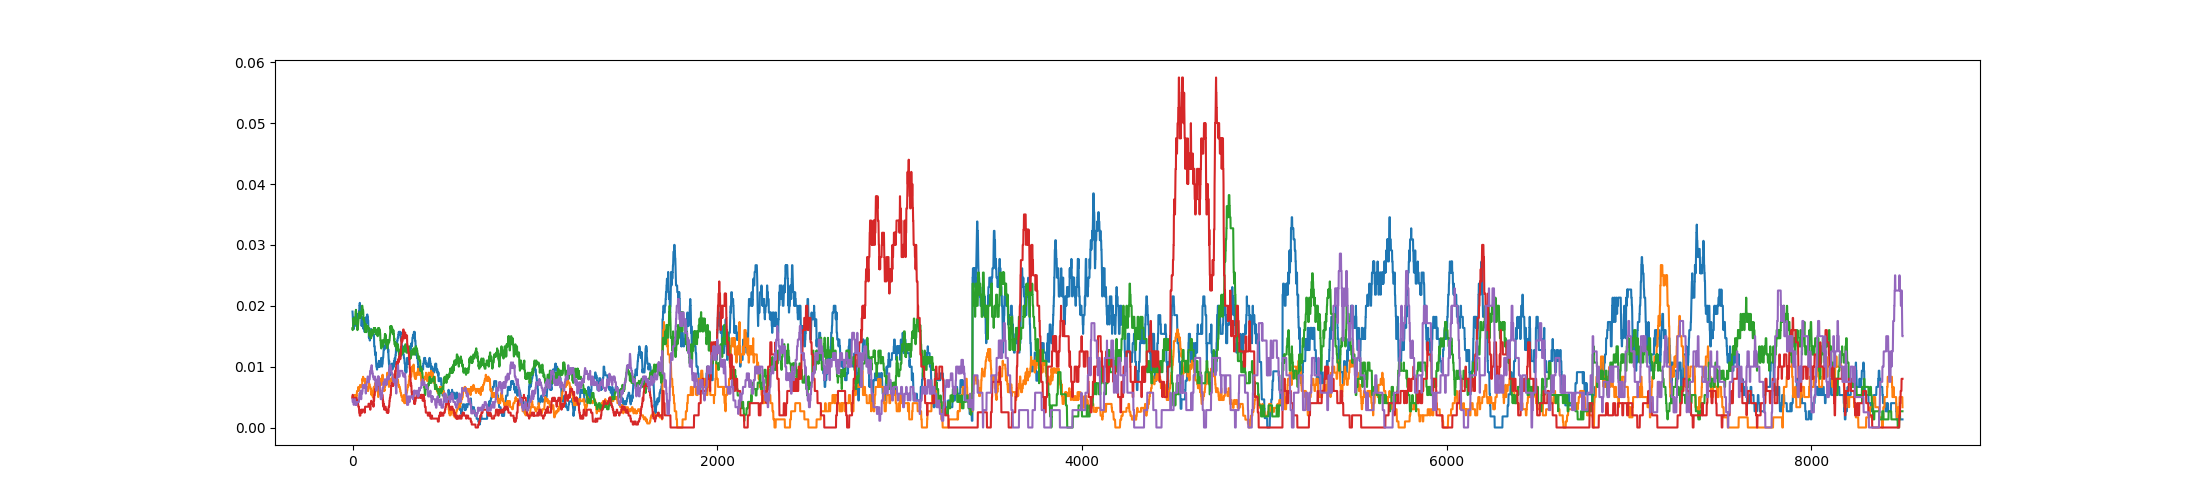

In [97]:
plt.subplots(figsize=(22,5))
_=plt.plot(neurons_fr[0:5].T)

In [98]:
neurons_fr[:100,].shape

(100, 8500)

In [99]:
n_comp = 50#zs_fr.shape[0]
model = PCA(n_components=n_comp).fit(neurons_fr.T)
C = model.components_
pc_s = C @ neurons_fr
model

PCA(n_components=50)

In [100]:
pc_s.reshape(n_comp,-1,end-start).shape

(50, 5, 1700)

In [101]:
colors_g=['#00009C',
        '#0009AF',
        '#002EB9',
        '#0054BE',
        '#0079C0',
        '#009CC1',
        '#00BDC2',
        '#00C2A8',
        '#00C18B',
        '#02BF71',
        '#01D723',
        '#02E302',
        '#03EE03',
        '#25FA03',
        '#5BFF04',
        '#98FF05',
        '#DEFF05']

IndexError: index 1700 is out of bounds for axis 0 with size 1700

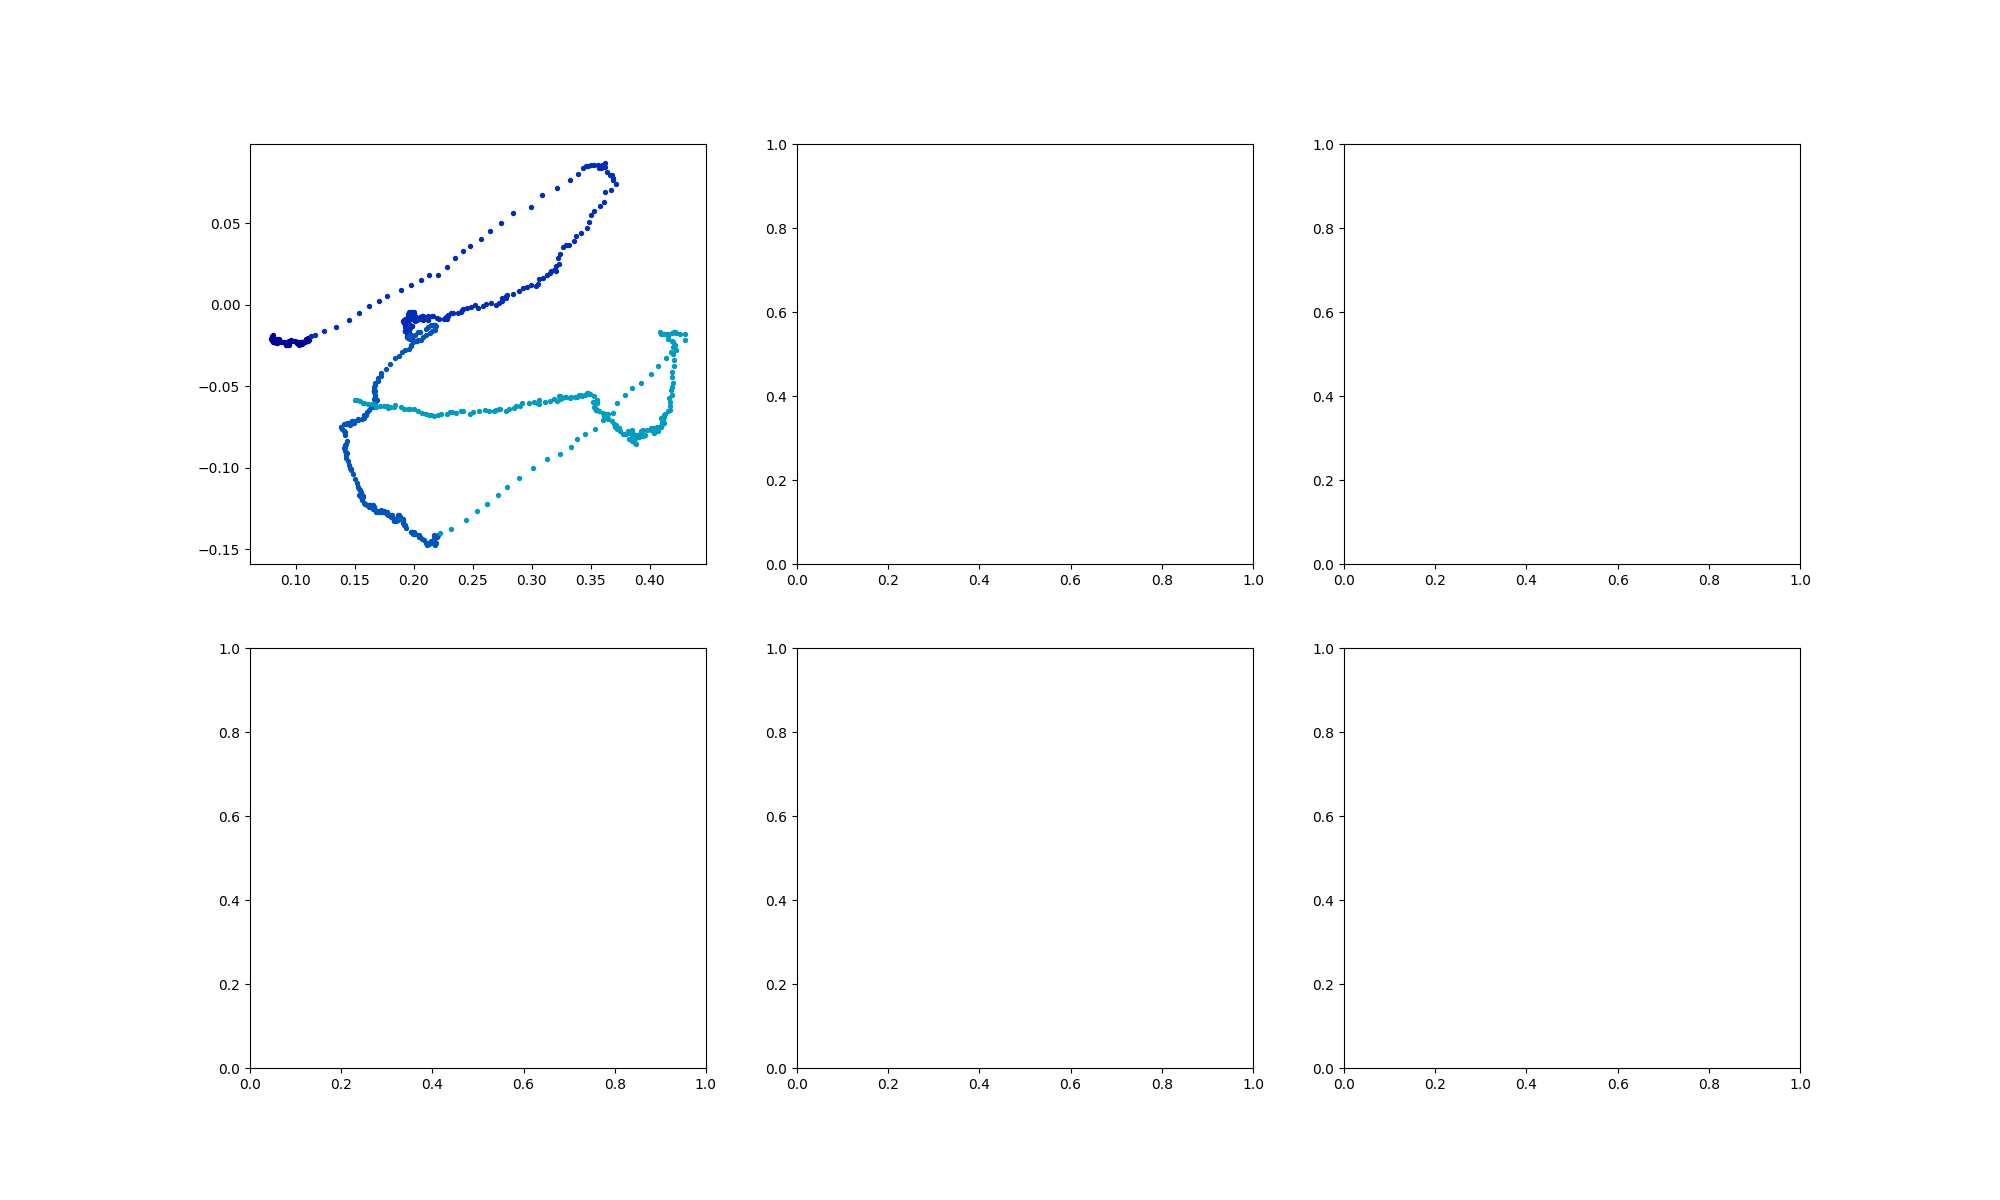

In [102]:
test1_st =200+450+400
test2_st = test1_st+450
test3_st = test2_st+450
test4_st = test3_st+450
test5_st = test4_st+450

reshape_pc_s = pc_s.reshape(n_comp,-1,end-start)
# #co_pcs = reshape_pc_s[:,0,:]
mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
i=0
fig,ax = plt.subplots(2,3,figsize=(20,12))#,sharex=True,sharey=True)
idx_f = np.arange(0,200,2)
idx_s = np.arange(200,200+450,2)
idx_d = np.arange(200+450,test1_st,2)
idx_t1 = np.arange(test1_st,test2_st,2)
idx_t2 = np.arange(test2_st,test3_st,2)
idx_t3 = np.arange(test3_st,test4_st,2)
idx_t4 = np.arange(test4_st,test5_st,2)
idx_aftert = np.arange(test4_st,mean_pc_s.shape[1],2)
count=0
j_ax=0
i_ax = 0
for i in np.arange(0,4):
    for j in np.arange(0+i,4):
        if i==j:
            continue
        if j_ax>=3: 
            i_ax = 1 
            j_ax = 0
        ax[i_ax,j_ax].scatter(mean_pc_s[i][idx_f],mean_pc_s[j][idx_f],s=8,color=colors_g[0],label='fixation')
        ax[i_ax,j_ax].scatter(mean_pc_s[i][idx_s],mean_pc_s[j][idx_s],s=8,color=colors_g[2],label='sample first part')
        ax[i_ax,j_ax].scatter(mean_pc_s[i][idx_d],mean_pc_s[j][idx_d],s=8,color=colors_g[3],label='delay')
        ax[i_ax,j_ax].scatter(mean_pc_s[i][idx_t1],mean_pc_s[j][idx_t1],s=8,color=colors_g[5],label='test1')
        ax[i_ax,j_ax].scatter(mean_pc_s[i][idx_t2],mean_pc_s[j][idx_t2],s=8,color=colors_g[9],label='test2')
        
        ax[i_ax,j_ax].scatter(mean_pc_s[i][idx_t3],mean_pc_s[j][idx_t3],s=5,color=colors_g[15],label='test3')
        ax[i_ax,j_ax].scatter(mean_pc_s[i][idx_aftert],mean_pc_s[j][idx_aftert],s=8,color=colors_g[16],label='test 3 off')
        # ax[i_ax,j_ax].scatter(mean_pc_s[i][idx_t3],mean_pc_s[j][idx_t3],s=5,color='y',label='test4')

        ax[i_ax,j_ax].set(xlabel="PC "+str(i+1), ylabel="PC "+str(j+1))
        j_ax+=1

fig.suptitle('lip')
ax[0,0].legend(fontsize=10,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper left')
fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)

In [ ]:
greyscale=['#000000',
            '#000000',
            '#0F0F0F',
            '#1F1F1F',
            '#2E2E2E',
            '#3D3D3D',
            '#4D4D4D',
            '#5C5C5C',
            '#6B6B6B',
            '#7A7A7A',
            '#8A8A8A',
            '#999999',
            '#A8A8A8',
            '#B8B8B8',
            '#C7C7C7',
            '#D6D6D6',
            '#E6E6E6',
            '#F5F5F5']
len(greyscale)

18

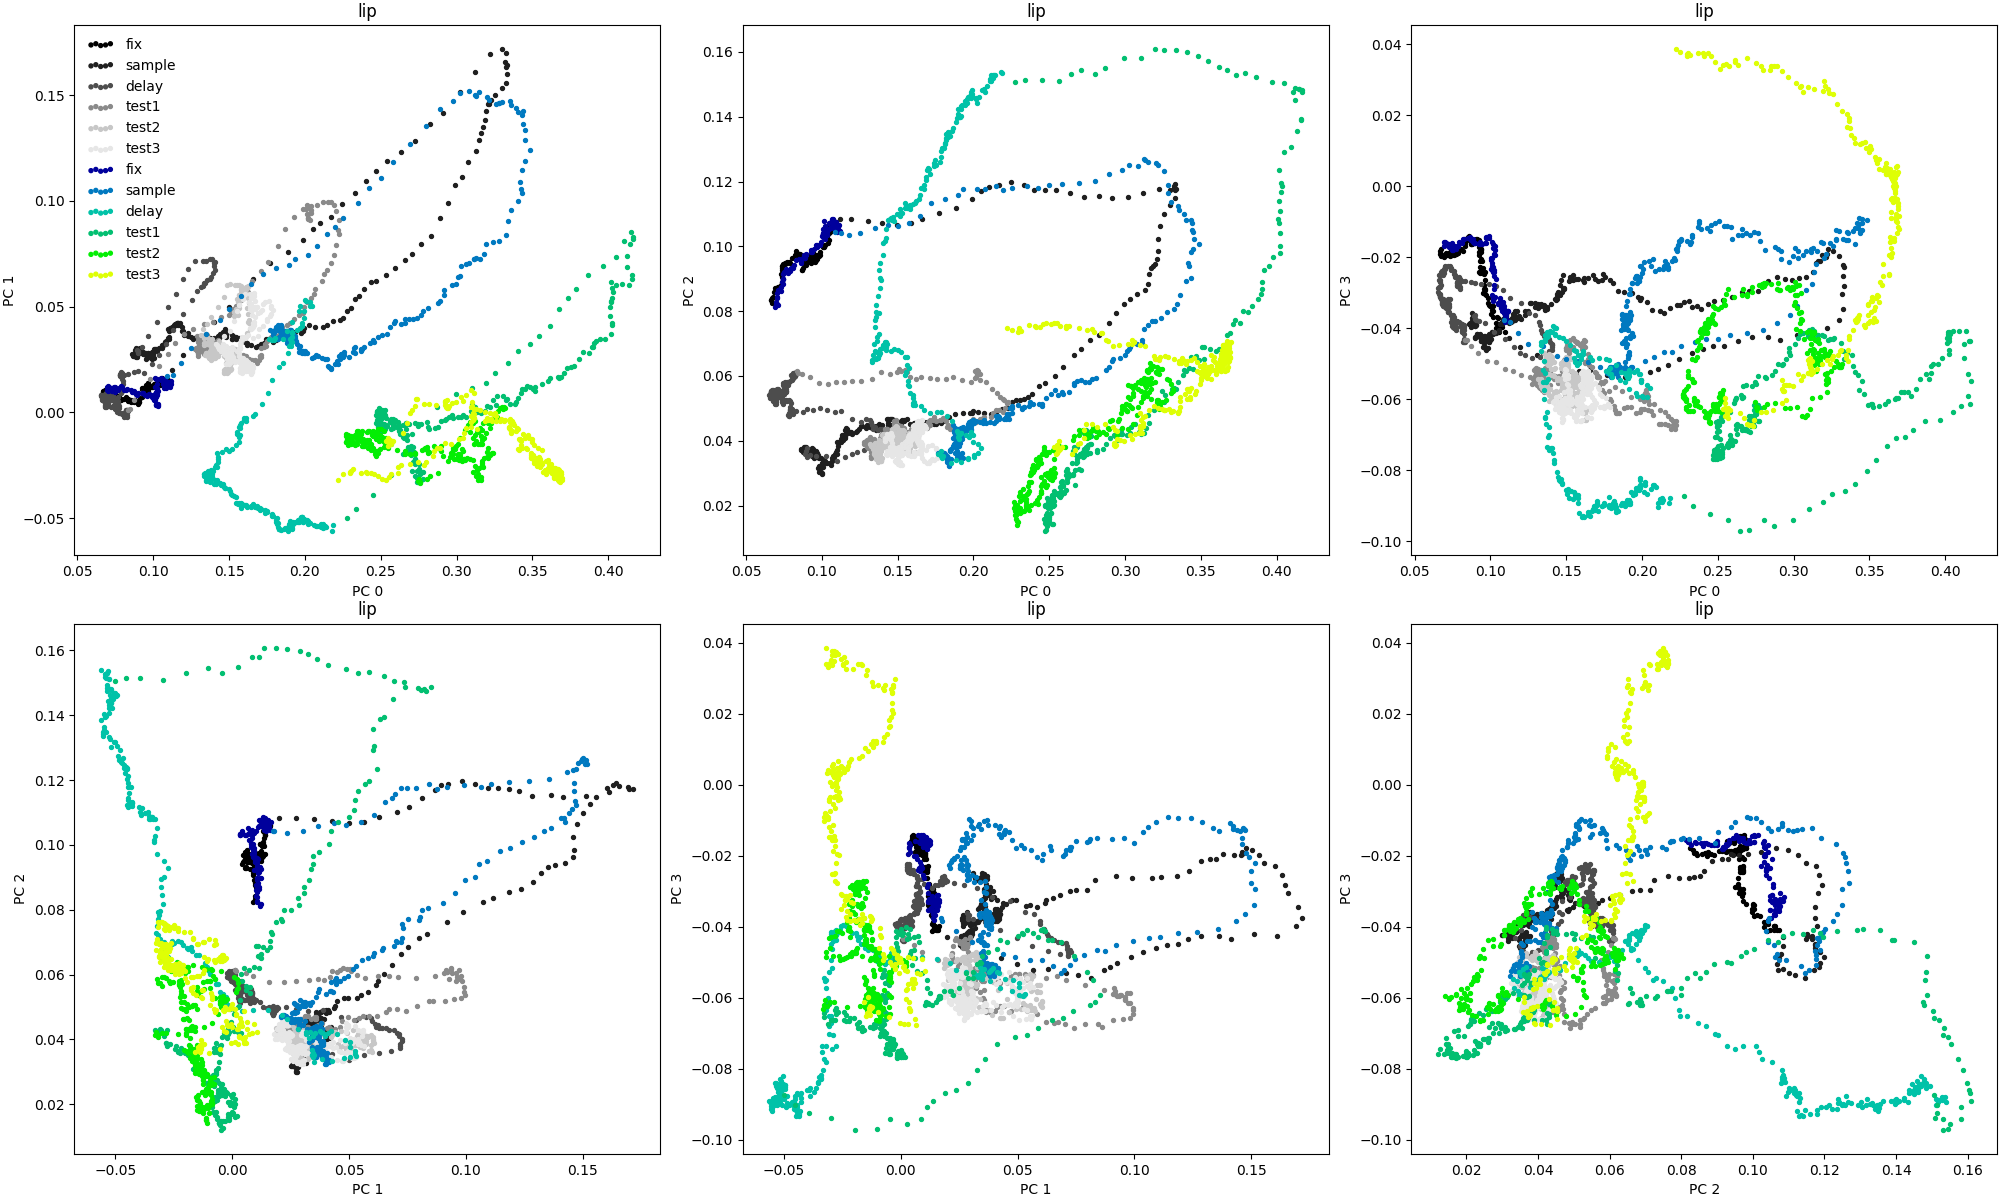

In [ ]:
# #co_pcs = reshape_pc_s[:,0,:]
i=0
fig,ax = plt.subplots(2,3,figsize=(20,12))#,sharex=True,sharey=True)
j_ax=0
i_ax = 0
for i in np.arange(0,4):
    for j in np.arange(0+i,4):
        if i==j:
            continue
        if j_ax>=3: 
            i_ax = 1 
            j_ax = 0
        # neutral
        ax[i_ax,j_ax].scatter(reshape_pc_s[i,0,idx_f],reshape_pc_s[j,0,idx_f],s=8,color=greyscale[0],label='fix')
        ax[i_ax,j_ax].scatter(reshape_pc_s[i,0,idx_s],reshape_pc_s[j,0,idx_s],s=8,color=greyscale[3],label='sample')
        ax[i_ax,j_ax].scatter(reshape_pc_s[i,0,idx_d],reshape_pc_s[j,0,idx_d],s=8,color=greyscale[6],label='delay')
        ax[i_ax,j_ax].scatter(reshape_pc_s[i,0,idx_t1],reshape_pc_s[j,0,idx_t1],s=8,color=greyscale[10],label='test1')
        ax[i_ax,j_ax].scatter(reshape_pc_s[i,0,idx_t2],reshape_pc_s[j,0,idx_t2],s=8,color=greyscale[14],label='test2')
        ax[i_ax,j_ax].scatter(reshape_pc_s[i,0,idx_t3],reshape_pc_s[j,0,idx_t3],s=8,color=greyscale[16],label='test3')
        # sample
        ax[i_ax,j_ax].scatter(mean_pc_s[i,idx_f],mean_pc_s[j,idx_f],s=8,color=colors_g[0],label='fix')
        ax[i_ax,j_ax].scatter(mean_pc_s[i,idx_s],mean_pc_s[j,idx_s],s=8,color=colors_g[4],label='sample')
        ax[i_ax,j_ax].scatter(mean_pc_s[i,idx_d],mean_pc_s[j,idx_d],s=8,color=colors_g[7],label='delay')
        ax[i_ax,j_ax].scatter(mean_pc_s[i,idx_t1],mean_pc_s[j,idx_t1],s=8,color=colors_g[9],label='test1')
        ax[i_ax,j_ax].scatter(mean_pc_s[i,idx_t2],mean_pc_s[j,idx_t2],s=8,color=colors_g[12],label='test2')
        ax[i_ax,j_ax].scatter(mean_pc_s[i,idx_t3],mean_pc_s[j,idx_t3],s=8,color=colors_g[16],label='test3')
        # ax[i_ax,j_ax].scatter(mean_pc_s[i,,mean_pc_s[j,,'--',s=8,color='g',label='neutr')
        # ax[i_ax,j_ax].scatter(mean_pc_s[i,,mean_pc_s[j,,'--',s=8,color='g',label='neutr')
        # ax[i_ax,j_ax].scatter(mean_pc_s[i,,mean_pc_s[j,,'--',s=8,color='g',label='neutr')
        ax[i_ax,j_ax].set(xlabel="PC "+str(i), ylabel="PC "+str(j),title='lip')
        j_ax+=1
ax[0,0].legend(fontsize=10,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper left')
fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)

In [ ]:
# reshape_pc_s = pc_s.reshape(n_comp,-1,1050)


# mean_co_pcs = np.mean(co_pcs,axis=1)

# fig,ax = plt.subplots(4,1,figsize=(10,10),sharex=True,sharey=True)
    
# for i_pc in np.arange(0,4):
#     for i_cond in np.arange(4):
#         n_pcs = reshape_pc_s[i_pc,i_cond,:]

#         ax[i_pc].plot(n_pcs,label=i_cond)

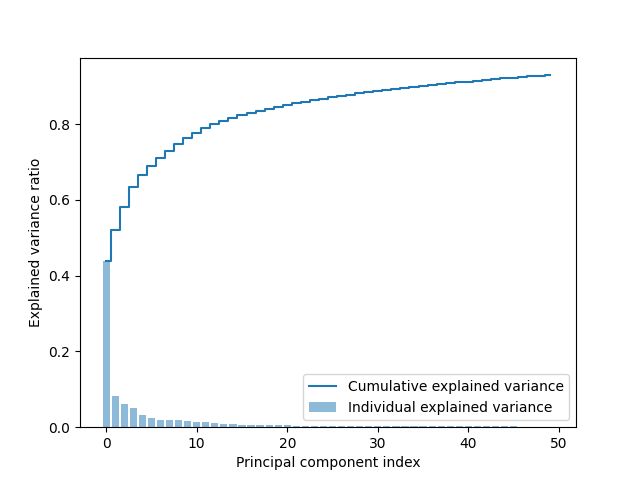

In [ ]:
fig,ax = plt.subplots()
exp_var_pca = model.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [ ]:
np.where(cum_sum_eigenvalues>0.8)[0][0]

12

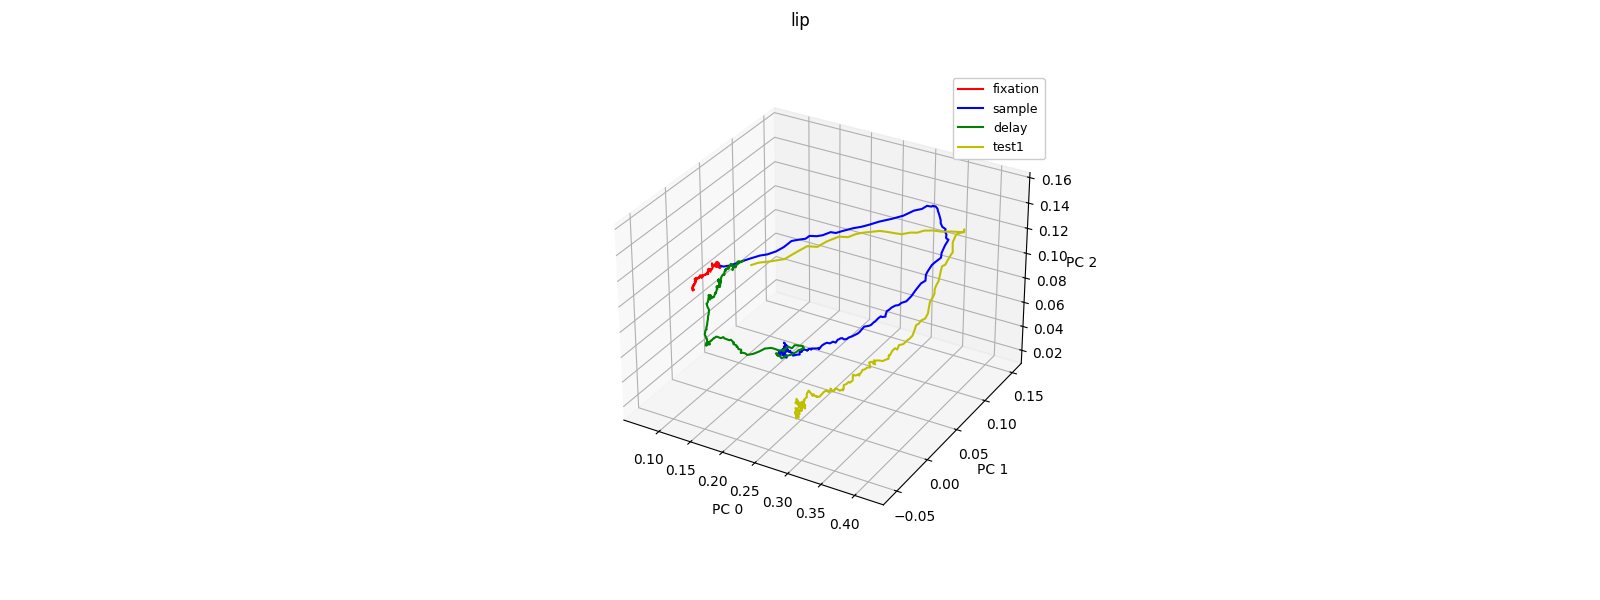

In [ ]:
fig,ax = plt.subplots(figsize=(16,6),sharey=True,sharex=True, subplot_kw={'projection': '3d'})#
i=0
area='lip'
reshape_pc_s = pc_s.reshape(n_comp,-1,end-start)
reshape_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
ax.plot(reshape_pc_s[i][idx_f],reshape_pc_s[i+1][idx_f],reshape_pc_s[i+2][idx_f],'r',label='fixation')
ax.plot(reshape_pc_s[i][idx_s],reshape_pc_s[i+1][idx_s],reshape_pc_s[i+2][idx_s],'b',label='sample')
ax.plot(reshape_pc_s[i][idx_d],reshape_pc_s[i+1][idx_d],reshape_pc_s[i+2][idx_d],'g',label='delay')
ax.plot(reshape_pc_s[i][idx_t1],reshape_pc_s[i+1][idx_t1],reshape_pc_s[i+2][idx_t1],'y',label='test1')
# ax.plot(reshape_pc_s[i][idx_t2],reshape_pc_s[i+1][idx_t2],reshape_pc_s[i+2][idx_t2],'m',label='test2')
# ax.plot(reshape_pc_s[i][idx_t3],reshape_pc_s[i+1][idx_t3],reshape_pc_s[i+2][idx_t3],'c',label='test3')



fig.suptitle(area)
ax.set(xlabel="PC "+str(i), ylabel="PC "+str(i+1), zlabel="PC "+str(i+2))
ax.legend(fontsize=9,columnspacing=0.5,facecolor='white', framealpha=1,loc='upper right')